In [3]:
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

students = pd.read_csv("С:\stud_math.csv")
#print(students.info())
students.rename(columns={'studytime, granular':'granular'}, inplace=True) # just rename one column to more appropriate
#print(students.info())

'''
Согласно условию ряд категориальных признаков (Medu, Fedu, traveltime, studytime, failures) принимают значения от 1 до 4 включительно.
Превышение этих значений будет ошибкой. Проверим на наличие таких ошибок.
'''

for col in ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures']:
    list(map(lambda item: print('не корректн. значения:',col, item) if item > 4 else None, students[col]))

#только одно значение в поле Fedu не отвечает условию. Предполагаем, что это ошибка. Заменим его на 4.
students.Fedu = students.Fedu.replace(40,4)

#тоже сделаем для признаков famrel, freetime, goout, health. Но проверим на не превышение 5
for col in ['famrel','freetime','goout','health']:
    list(map(lambda item: print('не корректн. значения:',col, item) if item > 5 else None, students[col]))
#тут все хорошо

#проверим ключевой показатель score на выбросы
score_qunt_25 = students.score.quantile(q=0.25,  interpolation='linear')
score_qunt_75 = students.score.quantile(q=0.75,  interpolation='linear')
score_std = np.std(students.score)
for row in students.score:
    if row < score_qunt_25-score_std*1.5 or row > score_qunt_75+score_std*1.5:
        print(row)


не корректн. значения: Fedu 40.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [4]:
# из выбросов в score присутствуют только значение 0. Но принимая во внимание количество таких значений не станем принимать 
# это за ошибибку или аномалию, считаем, что это реальная оценка
# описание аналитик Medu & Fedu содержит категорию  0-нет. Делаем предположение, что в 21-ом века начальное образование 
# есть у всех, то наблюдения должны принимать значения от 1 до 4. Посмиотрим сколько таких записей.
print('Образование матери:\n',students.Medu.value_counts())
print('Образование отца:\n',students.Fedu.value_counts())

Образование матери:
 4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
Name: Medu, dtype: int64
Образование отца:
 2.0    106
3.0     96
4.0     89
1.0     78
0.0      2
Name: Fedu, dtype: int64


In [5]:
# значений 0 не так много, но попробуем их заменить. Оценим как это раполагается в группах мать-отец
print(students.pivot_table(index=['Medu'], columns=['Fedu'], values=['school'], aggfunc='count'))

     school                        
Fedu    0.0   1.0   2.0   3.0   4.0
Medu                               
0.0     NaN   1.0   2.0   NaN   NaN
1.0     1.0  36.0  13.0   5.0   1.0
2.0     NaN  27.0  47.0  17.0   7.0
3.0     NaN  13.0  25.0  34.0  18.0
4.0     1.0   NaN  18.0  39.0  63.0


In [6]:
# pivot_table показывает явную тенденцию, которая располагается по главной диогонали - 
# образование отца соответствует образованию матери. Тогда все значени 0 или NaN заменим на соответствующее образование супруга.
students['Medu'] = students.apply(lambda row: row['Fedu'] if row['Medu'] == 0 or pd.isnull(row['Medu']) else row['Medu'], axis=1)
students['Fedu'] = students.apply(lambda row: row['Medu'] if row['Fedu'] == 0 or pd.isnull(row['Fedu']) else row['Fedu'], axis=1)

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64


<AxesSubplot:>

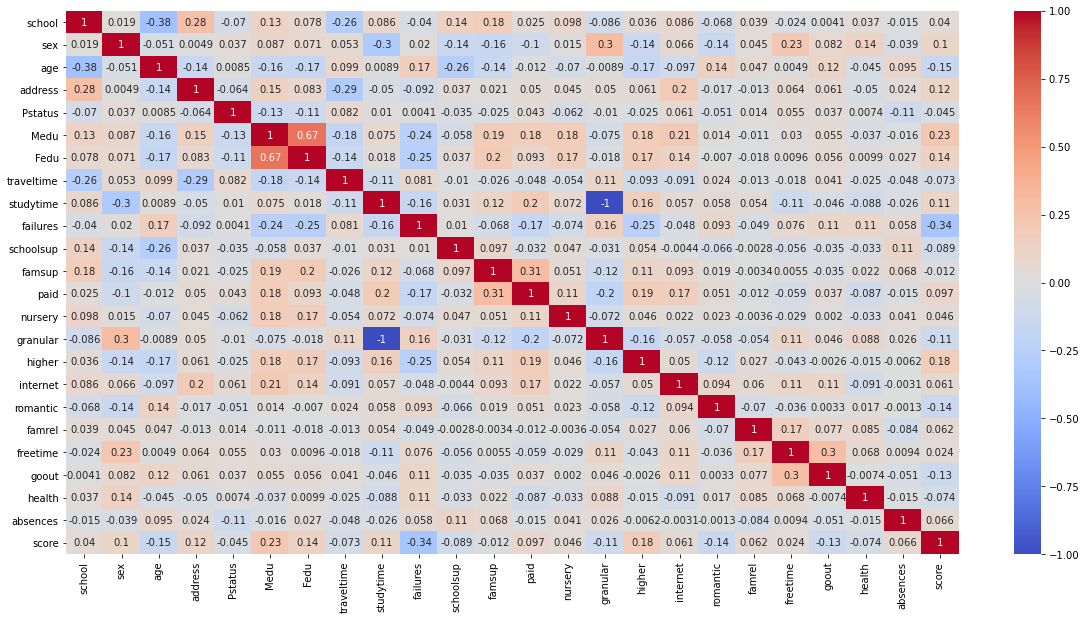

In [7]:
print(students.age.value_counts())
#мы удалим записи по вум  студентам 21 и 22 лет как единичные наблюдения, которые не являются репрезентативными для анализа
students = students[students.age <=20]

#переведем все поля с бинарными значеними в тип int для того, чтобы потом построить корреляцию 
cols = ["school","age","schoolsup","famsup","paid","activities","nursery","higher","internet","romantic","score",'Medu',
         "Fedu", "traveltime", "studytime", "failures","famrel","freetime","goout","health"]
students_corr = students.copy()
students_corr.replace(to_replace={"sex":{'M':1, 'F':0},
                            "address":{'U':1, 'R':0},
                             "Pstatus":{'T':1,'A':0},
                             "school":{'GP':1, 'MS':0},
                             "schoolsup":{'yes': 1,'no':0},
                             "famsup":{'yes': 1,'no':0},
                             "paid":{'yes': 1,'no':0},
                             "activity":{'yes': 1,'no':0},
                             "nursery":{'yes': 1,'no':0},
                             "higher":{'yes': 1,'no':0},
                             "internet":{'yes': 1,'no':0},
                             "romantic":{'yes': 1,'no':0}}, inplace=True)

fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(students_corr.corr(),ax=ax, annot=True, cmap='coolwarm')
#нас интересуют значения максимально близко к 1 или -1, что характеризует прямую или обратную корреляцию

In [8]:
# тепловая карта показывает, что наибольшую корреляцию score показывает со следующими категориями:
# age, higher, romantic, Medu, studityme, failures, goout, address Выделим их в отдельный датасет и опять построим heatmap
students_short = students_corr[['score', 'age', 'higher', 'romantic', 'Medu', 'studytime', 'failures', 'goout', 'address']]
#пока не удалось понять назначение поля granular. Это дубликат поля studytime с коэффициентом -3.

<AxesSubplot:>

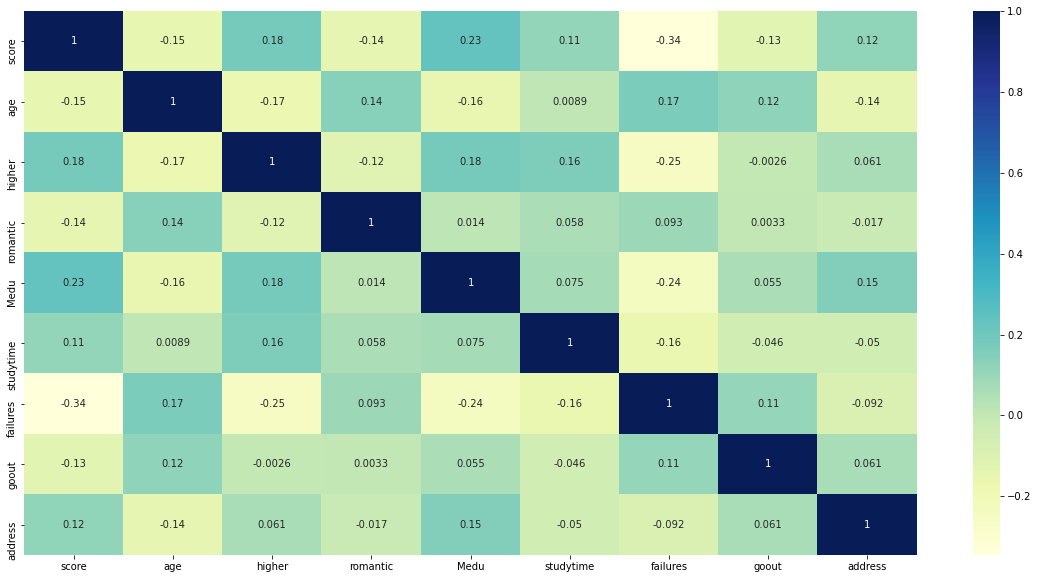

In [9]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(students_short.corr(),ax=ax, annot=True,cmap="YlGnBu")

In [10]:
# оценим пропуски в новом наборе
for col in students_short.columns:
    pct_missing = students_short[col].isna().mean()
    print(f'{col} - {pct_missing :.1%}')

score - 1.5%
age - 0.0%
higher - 4.8%
romantic - 7.9%
Medu - 0.0%
studytime - 1.8%
failures - 5.6%
goout - 2.0%
address - 4.3%


In [11]:
# вторым по значению параметром с пропусками есть failures. 
#В описании сказано количество внеучебных неудач (n, если 1<=n<=3, иначе 0). присвоим пропускам 0
students['failures'].fillna(0, inplace=True)
students_short = students[['score', 'age', 'higher', 'romantic', 'Medu', 'studytime', 'failures', 'goout']]
for col in students_short.columns:
    pct_missing = students_short[col].isna().mean()
    print(f'{col} - {pct_missing :.1%}')

score - 1.5%
age - 0.0%
higher - 4.8%
romantic - 7.9%
Medu - 0.0%
studytime - 1.8%
failures - 0.0%
goout - 2.0%


In [12]:
# кроме того, что выбранный набор категорий показывает заметную корреляцию к ключевому показателю score
# можно заметить, что так же разные категории демонстрируют значимую корреляцию между собой, например higher&Medu, age&failures
# дулаем вывод, что набор взаимосвязанных показателей

<AxesSubplot:xlabel='failures', ylabel='score'>

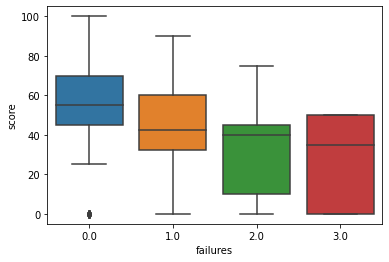

In [13]:
# построим ряд boxplot для выбранных категорий. Наибольшую корреляцию (обратную) score показывает с failures -0.34 
sns.boxplot(x='failures', y='score', data=students_short)
# явно заметно уменьшение оценки при увеличении внеучебных неудач. Учитыва, то это внеучебгые неудачи можно сделать вывод, 
# что и по другим предметам у данных увеников так же низкие оценки. У этих учеников не достает настойчивости. Внеучебные 
# неудачи в свое время показывают связь с higher, paid, age, Medu, studytime

<AxesSubplot:xlabel='Medu', ylabel='score'>

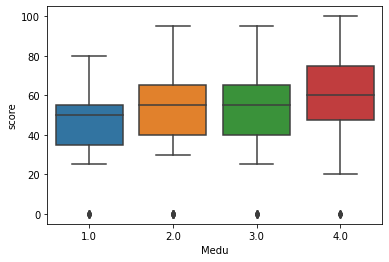

In [14]:
# следующим по значимости стоит категория Medu. Заметно повышение средней оценки с повышением показателя Medu. 
# при этом верхний квартиль у категорий Medu 2,3 и 4 стремиться к 100. Делаем предположенние, что матери с более высоким 
# образованием оказывают большее влияние на учебный процесс детей
sns.boxplot(x='Medu', y='score', data=students_short)

<AxesSubplot:xlabel='goout', ylabel='score'>

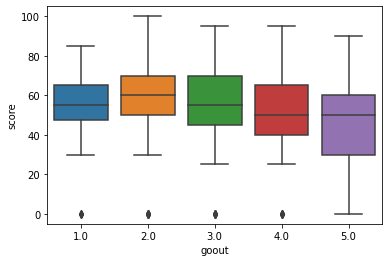

In [15]:
sns.boxplot(x='goout', y='score', data=students_short)

<AxesSubplot:xlabel='goout', ylabel='age'>

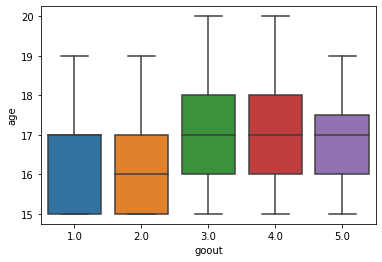

In [19]:
sns.boxplot(x='goout', y='age', data=students_short)

studytime
1.0    49.702970
2.0    50.820106
3.0    57.777778
4.0    56.296296
Name: score, dtype: float64

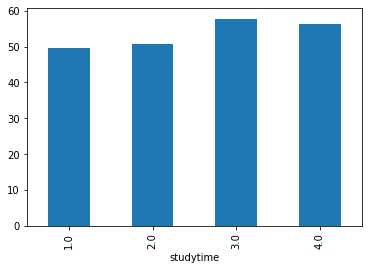

In [20]:
# анализ категорий goout&age показывает снижение оценки с увеличением проведения времени с друзьями. Так же заметно влияние 
# возраста детей в выборке. C 17 лет дети больше проводят время с друзьями.
students.groupby(['studytime'])['score'].mean().plot(kind='bar')
students.groupby(['studytime'])['score'].mean()

<AxesSubplot:xlabel='higher', ylabel='score'>

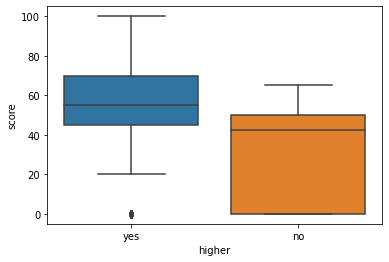

In [21]:
sns.boxplot(x='higher', y='score', data=students_short)

<AxesSubplot:xlabel='romantic', ylabel='score'>

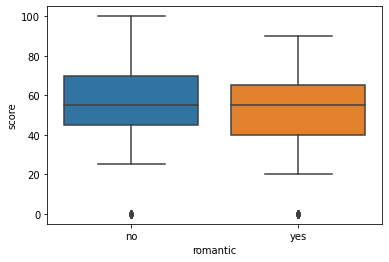

In [29]:
sns.boxplot(x='romantic', y='score', data=students_short)

In [28]:
# наличие романтических отношений оказывает определенное влияние на среднюю оценку. Это отрийцательное влияние.
# влияние географической локиции и интрнета на среднюю оценку
print(students.groupby(['address', 'internet'])['score'].mean())

address  internet
R        no          47.727273
         yes         46.759259
U        no          51.000000
         yes         54.334764
Name: score, dtype: float64


In [ ]:
# Address – ученики из города показывают оценки лучше чем их сверстники за городом. При этом прослеживается связь с 
# наличием интернета только у городских учеников. На загородных сверстников отсутствие интернета не оказывает значимого 
# влияния на среднюю оценку.  
# Выводы предоставлены в файле Выводы.doc